# Introduction

This lesson is a brief introduction to TOAST:  how data is represented in memory and how to build processing workflows.  First we import some packages we will use in this notebook.

In [1]:
# Built-in modules
import sys
import os

# External modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# TOAST
import toast


# Capture C++ output in the jupyter cells
%load_ext wurlitzer

# Display inline plots
%matplotlib inline

# Runtime Environment

The `toast` module can be influenced by a few environment variables, which must be set **before** importing `toast`:

In [2]:
help(toast)

Help on package toast:

NAME
    toast

DESCRIPTION
    Time Ordered Astrophysics Scalable Tools (TOAST) is a software package
    designed to allow the processing of data from telescopes that acquire
    data as timestreams (rather than images).
    
    Runtime behavior of this package can be controlled by setting some
    environment variables (before importing the package):
    
    TOAST_LOGLEVEL=<value>
        * Possible values are "VERBOSE", "DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL".
          Default is "INFO".
        * Controls logging of both C++ and Python code.
    
    TOAST_FUNCTIME=<value>
        * Any non-empty value will enable python function timers in many parts of the code
    
    TOAST_TOD_BUFFER=<integer>
        * Number of elements to buffer in code where many intermediate timestream
          products are created.  Default is 1048576.
    
    OMP_NUM_THREADS=<integer>
        * Toast uses OpenMP threading in several places and the concurrency is set 

In [3]:
toast?

You can get the current TOAST runtime configuration from the "Environment" class.

In [4]:
env = toast.Environment.get()
print(env)

<toast.Environment
  Source code version = 2.3.12.dev137
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 8
>


The logging level can be changed by either setting the `TOAST_LOGLEVEL` environment variable to one of the supported levels (`VERBOSE`, `DEBUG`, `INFO`, `WARNING`, `ERROR`, `CRITICAL`) or by using the `set_log_level()` method of the `Environment` class.  The maximum number of threads is controlled by the standard `OMP_NUM_THREADS` environment variable.

# Data Model

The basic data model in a toast workflow consists of a set of `Observation` instances, each of which is associated with a `Focalplane` on a `Telescope`.  Note that a Focalplane instance is probably just a sub-set of detectors on the actual physical focalplane.  These detectors must be co-sampled and likely have other things in common (for example, they are on the same wafer or are correlated in some other way).  For this notebook, we will manually create these objects, but usually these will be loaded / created by some experiment-specific function.

MPI is completely optional in TOAST, although it is required to achieve good parallel performance on systems with many (e.g. 4 or more) cores.  Most of the parallelism in TOAST is MPI process-based, not threaded.  In this section we show how interactive use of TOAST can be done without any reference to MPI.  In a separate notebook in this directory we show how to make use of distributed data and operations in parallel workflows.


In [5]:
# Start by making a fake focalplane

from toast.instrument_sim import (
    fake_hexagon_focalplane,
    plot_focalplane,
)

focalplane_pixels = 7 # (hexagonal, pixel zero at center)
field_of_view = 10.0 * u.degree
sample_rate = 10.0 * u.Hz

focalplane = fake_hexagon_focalplane(
    n_pix=focalplane_pixels,
    width=field_of_view,
    sample_rate=sample_rate,
    epsilon=0.0,
)


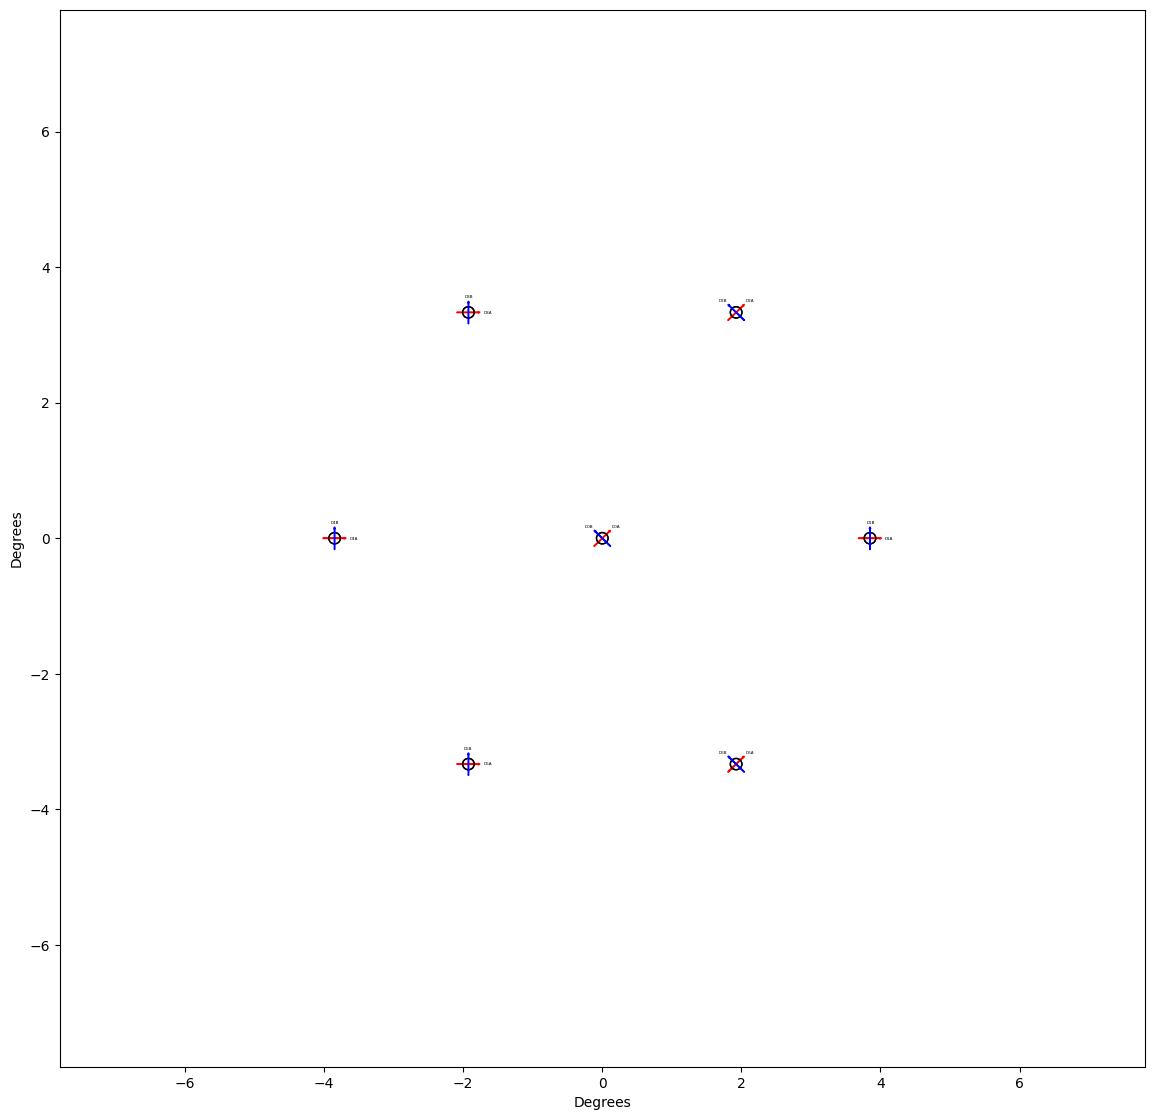

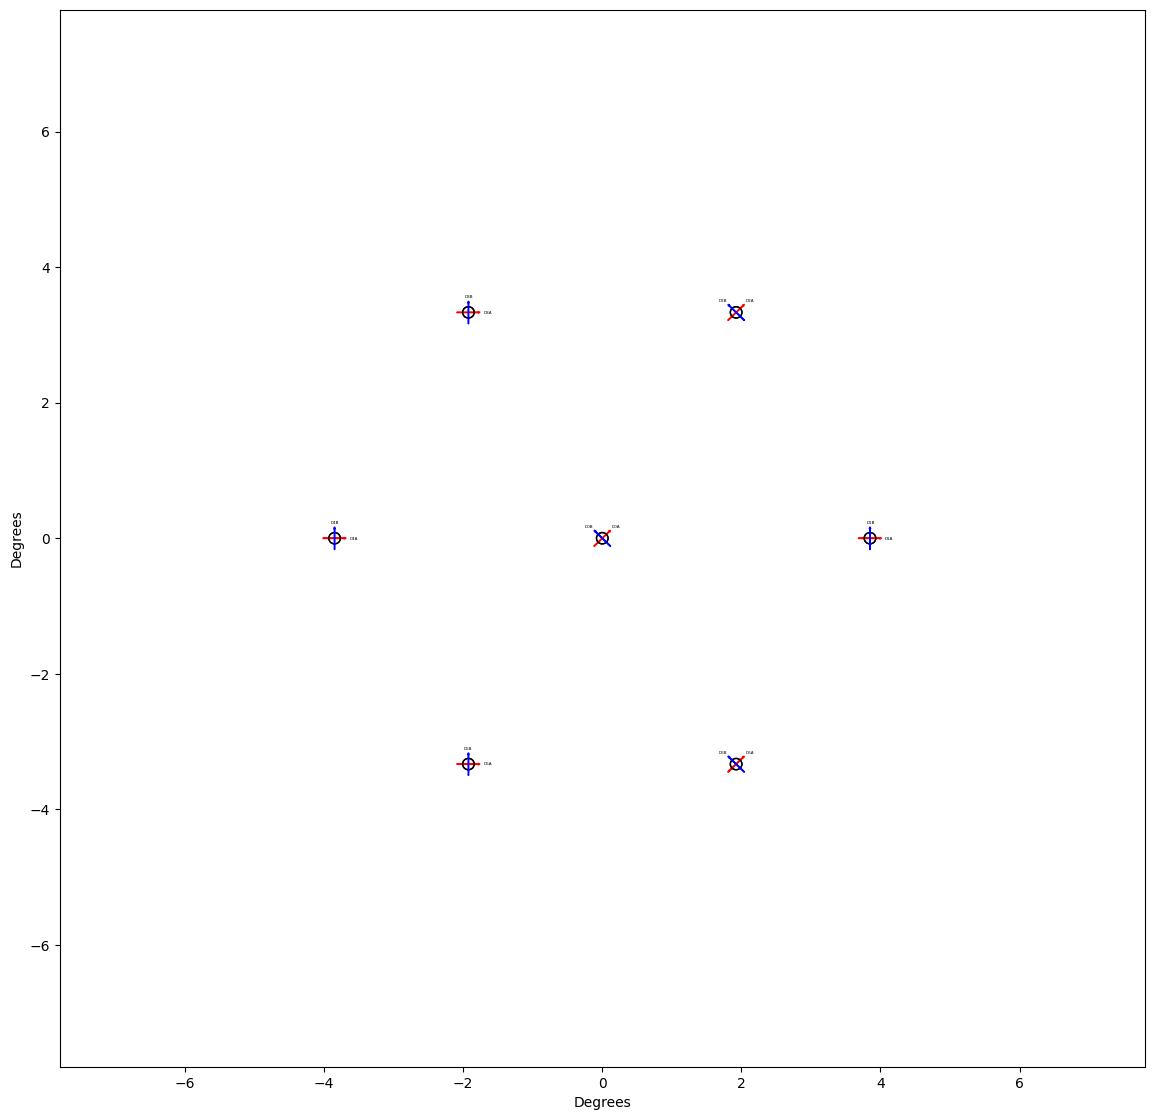

In [6]:
# Make a plot of this focalplane layout.

detpolcol = {
    x: "red" if x.endswith("A") else "blue" for x in focalplane.detectors
}

plot_focalplane(
    focalplane=focalplane,
    width=1.3 * field_of_view,
    height=1.3 * field_of_view,
    show_labels=True,
    pol_color=detpolcol
)

In [7]:
# Now make a fake telescope

telescope = toast.Telescope(name="fake", focalplane=focalplane, site=toast.SpaceSite(name="L2"))

Now that we have a fake telescope created, we can create an observation:

In [8]:
# Make an empty observation

samples = 10

ob = toast.Observation(
    telescope, 
    name="2020-07-31_A", 
    n_samples=samples
)

print(ob)

<Observation
  name = '2020-07-31_A'
  uid = '2881371475'  group has a single process (no MPI)
  telescope = <Telescope 'fake': uid = 4020063252, site = <SpaceSite 'L2' : uid = 3584191102>, focalplane = <Focalplane: 14 detectors, sample_rate = 10.0 Hz, FOV = 7.774983625086865 deg, detectors = [D0A .. D6B]>>
  10 samples
  shared:  <SharedDataMgr>
  detdata:  <DetDataMgr 14 local detectors, 10 samples>
  intervals:  <IntervalMgr 0 lists>
>


Here we see our observation simply has the starting information we passed to the constructor.  Next we will discuss the 3 types of data objects that can be stored in an Observation:  detector data products, shared telescope data, and arbitrary metadata.

## Metadata

By default, the observation is empty.  You can add arbitrary metadata to the observation- it acts just like a dictionary.

In [9]:
hk = {
    "Temperature 1": np.array([1.0, 2.0, 3.0]),
    "Other Sensor": 1.2345
}

ob["housekeeping"] = hk

print(ob)

<Observation
  name = '2020-07-31_A'
  uid = '2881371475'  group has a single process (no MPI)
  telescope = <Telescope 'fake': uid = 4020063252, site = <SpaceSite 'L2' : uid = 3584191102>, focalplane = <Focalplane: 14 detectors, sample_rate = 10.0 Hz, FOV = 7.774983625086865 deg, detectors = [D0A .. D6B]>>
  housekeeping = {'Temperature 1': array([1., 2., 3.]), 'Other Sensor': 1.2345}
  10 samples
  shared:  <SharedDataMgr>
  detdata:  <DetDataMgr 14 local detectors, 10 samples>
  intervals:  <IntervalMgr 0 lists>
>


Metadata like this is not synchronized in any way between processes.  A user or Operator can put any keys here to store small data objects.

## Detector Data

Detector data has some unique properties that we often want to leverage in our analyses. Each process has some detectors and some time slice of the observation. In the case of a single process like this example, all the data is local. Before using data we need to create it within the empty Observation. Here we create a "signal" object for the detectors.  The detector data is accessed under the `detdata` attribute of the observation:


**FIXME:  talk about naming conventions**

Here we create and initialize to zero some detector data named "signal".  This has one value per sample per detector and each value is a 64bit float.

In [10]:
ob.detdata.create("signal", dtype=np.float64)

In [11]:
print(ob.detdata)

<DetDataMgr 14 local detectors, 10 samples
    signal: shape = (14, 10), dtype = float64>


In [12]:
print(ob.detdata["signal"])

<DetectorData 14 detectors each with shape (10,) and type float64:
  D0A = [ 0.0 0.0 ... 0.0 0.0 ]
  D1A = [ 0.0 0.0 ... 0.0 0.0 ]
  D2A = [ 0.0 0.0 ... 0.0 0.0 ]
  D3A = [ 0.0 0.0 ... 0.0 0.0 ]
  D4A = [ 0.0 0.0 ... 0.0 0.0 ]
  D5A = [ 0.0 0.0 ... 0.0 0.0 ]
  D6A = [ 0.0 0.0 ... 0.0 0.0 ]
  D0B = [ 0.0 0.0 ... 0.0 0.0 ]
  D1B = [ 0.0 0.0 ... 0.0 0.0 ]
  D2B = [ 0.0 0.0 ... 0.0 0.0 ]
  D3B = [ 0.0 0.0 ... 0.0 0.0 ]
  D4B = [ 0.0 0.0 ... 0.0 0.0 ]
  D5B = [ 0.0 0.0 ... 0.0 0.0 ]
  D6B = [ 0.0 0.0 ... 0.0 0.0 ]
>


You can create other types of detector data, and there is some shortcut notation that can be used to create detector data objects from existing arrays.  For example:

In [13]:
# This takes an existing N_detector x N_sample array and creates from that

some_data = 3.0 * np.ones(
    (
        len(ob.local_detectors), 
        ob.n_local_samples
    ),
    dtype=np.float32
)

ob.detdata["existing_signal"] = some_data
print(ob.detdata["existing_signal"])

<DetectorData 14 detectors each with shape (10,) and type float32:
  D0A = [ 3.0 3.0 ... 3.0 3.0 ]
  D1A = [ 3.0 3.0 ... 3.0 3.0 ]
  D2A = [ 3.0 3.0 ... 3.0 3.0 ]
  D3A = [ 3.0 3.0 ... 3.0 3.0 ]
  D4A = [ 3.0 3.0 ... 3.0 3.0 ]
  D5A = [ 3.0 3.0 ... 3.0 3.0 ]
  D6A = [ 3.0 3.0 ... 3.0 3.0 ]
  D0B = [ 3.0 3.0 ... 3.0 3.0 ]
  D1B = [ 3.0 3.0 ... 3.0 3.0 ]
  D2B = [ 3.0 3.0 ... 3.0 3.0 ]
  D3B = [ 3.0 3.0 ... 3.0 3.0 ]
  D4B = [ 3.0 3.0 ... 3.0 3.0 ]
  D5B = [ 3.0 3.0 ... 3.0 3.0 ]
  D6B = [ 3.0 3.0 ... 3.0 3.0 ]
>


In [14]:
# This takes one detectors-worth of data and replicates it to all detectors
# while creating a new data object.

ob.detdata["replicated"] = 5 * np.ones(ob.n_local_samples, dtype=np.int32)
print(ob.detdata["replicated"])

<DetectorData 14 detectors each with shape (10,) and type int32:
  D0A = [ 5 5 ... 5 5 ]
  D1A = [ 5 5 ... 5 5 ]
  D2A = [ 5 5 ... 5 5 ]
  D3A = [ 5 5 ... 5 5 ]
  D4A = [ 5 5 ... 5 5 ]
  D5A = [ 5 5 ... 5 5 ]
  D6A = [ 5 5 ... 5 5 ]
  D0B = [ 5 5 ... 5 5 ]
  D1B = [ 5 5 ... 5 5 ]
  D2B = [ 5 5 ... 5 5 ]
  D3B = [ 5 5 ... 5 5 ]
  D4B = [ 5 5 ... 5 5 ]
  D5B = [ 5 5 ... 5 5 ]
  D6B = [ 5 5 ... 5 5 ]
>


In [15]:
# You can also create detector data objects from a dictionary
# of single-detector arrays
other = dict()
for i, d in enumerate(ob.local_detectors):
    other[d] = i * np.ones(ob.n_local_samples, dtype=np.int32)

ob.detdata["other_signal"] = other
print(ob.detdata["other_signal"])

<DetectorData 14 detectors each with shape (10,) and type int32:
  D0A = [ 0 0 ... 0 0 ]
  D0B = [ 7 7 ... 7 7 ]
  D1A = [ 1 1 ... 1 1 ]
  D1B = [ 8 8 ... 8 8 ]
  D2A = [ 2 2 ... 2 2 ]
  D2B = [ 9 9 ... 9 9 ]
  D3A = [ 3 3 ... 3 3 ]
  D3B = [ 10 10 ... 10 10 ]
  D4A = [ 4 4 ... 4 4 ]
  D4B = [ 11 11 ... 11 11 ]
  D5A = [ 5 5 ... 5 5 ]
  D5B = [ 12 12 ... 12 12 ]
  D6A = [ 6 6 ... 6 6 ]
  D6B = [ 13 13 ... 13 13 ]
>


By default you will get detector data with one element per sample and float64 dtype.  However, you can specify the shape of each detector sample:

In [16]:
# Example of data with different shape

ob.detdata.create("pointing", sample_shape=(4,), dtype=np.float32)
print(ob.detdata["pointing"])

<DetectorData 14 detectors each with shape (10, 4) and type float32:
  D0A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D1A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D2A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D3A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D4A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D5A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D6A = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D0B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D1B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D2B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D3B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D4B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
  D5B = [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0

### Details of Detector Data

In the commands above we created named data objects and each one seems to contain an array for each detector.  However, this container actually allocates memory in a single block, and you can slice the object both in the detector and sample direction.  For example:

In [17]:
# Access one detector by name
ob.detdata["signal"]["D0A"] = np.arange(samples, dtype=np.float64)

# Access one detector by index
ob.detdata["signal"][1] = 10.0 * np.arange(samples, dtype=np.float64)

# Slice by both detector and sample
ob.detdata["signal"][["D2A", "D2B"], 0:2] = 5.0

print(ob.detdata["signal"])

<DetectorData 14 detectors each with shape (10,) and type float64:
  D0A = [ 0.0 1.0 ... 8.0 9.0 ]
  D1A = [ 0.0 10.0 ... 80.0 90.0 ]
  D2A = [ 5.0 5.0 ... 0.0 0.0 ]
  D3A = [ 0.0 0.0 ... 0.0 0.0 ]
  D4A = [ 0.0 0.0 ... 0.0 0.0 ]
  D5A = [ 0.0 0.0 ... 0.0 0.0 ]
  D6A = [ 0.0 0.0 ... 0.0 0.0 ]
  D0B = [ 0.0 0.0 ... 0.0 0.0 ]
  D1B = [ 0.0 0.0 ... 0.0 0.0 ]
  D2B = [ 5.0 5.0 ... 0.0 0.0 ]
  D3B = [ 0.0 0.0 ... 0.0 0.0 ]
  D4B = [ 0.0 0.0 ... 0.0 0.0 ]
  D5B = [ 0.0 0.0 ... 0.0 0.0 ]
  D6B = [ 0.0 0.0 ... 0.0 0.0 ]
>


In [18]:
# Access the whole thing as a 2D array
print(ob.detdata["signal"][:])

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]
 [ 5.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Shared Data

Many types of data are common to multiple detectors.  Some examples would be telescope pointing, timestamps, other sensor data, etc.  When running in parallel we want to have just one copy of this data per node in order to save memory.  The shared data is accessed under the "shared" attribute of the observation.  For this serial notebook, you will not need to worry about the details of communicators, but when running in parallel it becomes important.  
For this serial notebook, the `shared` attribute will look very much like a dictionary of numpy arrays.  See the "parallel" intro notebook for more examples of using shared data when each observation is distributed across a grid of processes.

In [19]:
# Create some time stamps by assigning from an existing array on one process.
# When running with multiple processes, this syntax has extra communication.
ob.shared["times"] = np.arange(ob.n_local_samples, dtype=np.float64)
print(ob.shared["times"])

# Create and initialize to zero some boresight quaternions
ob.shared.create("boresight_radec", shape=(ob.n_local_samples, 4), dtype=np.float64)
print(ob.shared["boresight_radec"])

<MPIShared
  replicated on 1 nodes, each with 1 processes (1 total)
  shape = (10,), dtype = float64
  [ 0.0 1.0 ... 8.0 9.0 ]
>
<MPIShared
  replicated on 1 nodes, each with 1 processes (1 total)
  shape = (10, 4), dtype = float64
  [ [0. 0. 0. 0.] [0. 0. 0. 0.] ... [0. 0. 0. 0.] [0. 0. 0. 0.] ]
>


You can see that the data objects are a special "MPIShared" object from the [`pshmem`](https://pypi.org/project/pshmem/) package.  Shared data objects can be read with slicing notation just like normal numpy arrays:

In [20]:
print(ob.shared["boresight_radec"][:])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


However, they are intended to be "write once", "read many" objects.  You cannot simply assign data to them.  The reason is that the data is replicated across nodes and so setting array values must be a collective operation.

In [21]:
nullquat = np.array([0.0, 0.0, 0.0, 1.0])
full_data = np.tile(nullquat, ob.n_local_samples).reshape((-1, 4))

# In the serial case, simple assignment works just like array assignment
ob.shared["boresight_radec"][:] = full_data

# When running with MPI, the set() method avoids some communication
ob.shared["boresight_radec"].set(full_data, fromrank=0)

print(ob.shared["boresight_radec"])

<MPIShared
  replicated on 1 nodes, each with 1 processes (1 total)
  shape = (10, 4), dtype = float64
  [ [0. 0. 0. 1.] [0. 0. 0. 1.] ... [0. 0. 0. 1.] [0. 0. 0. 1.] ]
>


## Intervals

Each `Observation` may contain one or more "interval lists" which act as a global (within the observation) list of time / sample ranges where some feature of the data is constant.  Interval lists support sample-wise inversion, intersection and union operations using the standard python bitwise operators (`^`, `&`, and `|`).

Intervals are **not** intended to act as individual sample quality flags.  Per-sample flags should be created either as a shared timestream (for flags common to all detectors) or as a detector data object (for per-detector flags).  Intervals can be used to represent things changing less frequently, for example:  left or right moving telescope scans, satellite repointing maneuvers, calibration measurements, etc.

A single `Interval` consists of a time and a (local) sample range:

In [22]:
? toast.Interval

In [23]:
# The observation starts with no lists of intervals

ob.intervals

<IntervalMgr 0 lists>

To add a new interval list, use the `create()` method.  Remember, in this notebook we have only one process, so do not have to worry about which process this information is coming from:

In [24]:
help(ob.intervals.create)

Help on method create in module toast.observation_data:

create(name, global_timespans, local_times, fromrank=0) method of toast.observation_data.IntervalMgr instance
    Create local interval lists from global time ranges on one process.
    
    In some situations, a single process has loaded data from the disk, queried a
    database, etc and has information about some time spans that are global across
    the observation.  This function automatically creates the named local interval
    list consisting of the intersection of the local sample range with these global
    intervals.
    
    Args:
        name (str):  The key to use in the local intervals dictionary.
        global_timespans (list):  List of start, stop tuples containing time ranges
            within the observation.
        local_times (array):  The local timestamps on this process.
        fromrank (int):  Get the list from this process rank of the observation
            communicator.  Input arguments on other pro

Here we create one list of intervals.  We specify the time ranges and the local array of timestamp values.  Inside the code, the timestamps are used to convert these input time ranges into `Interval` objects.

In [25]:
ob.intervals.create("good", [(1.5, 3.5), (4.5, 6.), (7., 8.5)], ob.shared["times"])

In [26]:
# Now there is one interval list in the observation

print(ob.intervals)

<IntervalMgr 1 lists
  good: 3 intervals>


In [27]:
# The create method converted the time ranges into actual Interval instances:

print(ob.intervals["good"])

[<Interval 2.0 - 3.0 [2:3]>, <Interval 5.0 - 6.0 [5:6]>, <Interval 7.0 - 8.0 [7:8]>]


Now create another list of intervals:

In [28]:
ob.intervals.create("stable", [(0.5, 2.5), (3.5, 5.), (6., 7.5)], ob.shared["times"])
print(ob.intervals)

<IntervalMgr 2 lists
  good: 3 intervals
  stable: 3 intervals>


As mentioned before, we can combine these in different ways:

In [29]:
ob.intervals["stable-and-not-good"] = ob.intervals["stable"] & ~ob.intervals["good"]

print(ob.intervals)
print(ob.intervals["stable-and-not-good"])

<IntervalMgr 3 lists
  good: 3 intervals
  stable: 3 intervals
  stable-and-not-good: 2 intervals>
[<Interval 1.0 - 1.0 [1:1]>, <Interval 4.0 - 4.0 [4:4]>]


In [30]:
ob.intervals["not-stable-or-not-good"] = ~ob.intervals["stable"] | ~ob.intervals["good"]

print(ob.intervals)
print(ob.intervals["not-stable-or-not-good"])

<IntervalMgr 4 lists
  good: 3 intervals
  stable: 3 intervals
  stable-and-not-good: 2 intervals
  not-stable-or-not-good: 3 intervals>
[<Interval 0.0 - 1.0 [0:1]>, <Interval 3.0 - 4.0 [3:4]>, <Interval 8.0 - 9.0 [8:9]>]


## Views

Typically when defining data intervals in the last section it is because you want to do something with only the data falling in those sample ranges.  Each observation has the ability to provide a "view" into the detector and shared data given by a previously defined interval list.  Views are created on the fly on first access and are deleted automatically if the underlying interval is deleted.  First, examine a view of the "good" interval list we defined in the previous section:

In [31]:
print(ob.view["good"])

[slice(2, 4, 1), slice(5, 7, 1), slice(7, 9, 1)]


The string represention of a view is just a list of sample slices.  However, the real power is that we can get a view of any of the observation `detdata` or `shared` objects.  For example, we could get a view of the detector `signal` data.  Recall that the full data for this is:

In [32]:
ob.detdata["signal"][:]

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

A view of the signal data falling in the "good" intervals is:

In [33]:
ob.view["good"].detdata["signal"][:]

[<DetectorData (view) 14 detectors each with shape (2,) and type float64:
   D0A = [ 2.0 3.0 ]
   D1A = [ 20.0 30.0 ]
   D2A = [ 0.0 0.0 ]
   D3A = [ 0.0 0.0 ]
   D4A = [ 0.0 0.0 ]
   D5A = [ 0.0 0.0 ]
   D6A = [ 0.0 0.0 ]
   D0B = [ 0.0 0.0 ]
   D1B = [ 0.0 0.0 ]
   D2B = [ 0.0 0.0 ]
   D3B = [ 0.0 0.0 ]
   D4B = [ 0.0 0.0 ]
   D5B = [ 0.0 0.0 ]
   D6B = [ 0.0 0.0 ]
 >,
 <DetectorData (view) 14 detectors each with shape (2,) and type float64:
   D0A = [ 5.0 6.0 ]
   D1A = [ 50.0 60.0 ]
   D2A = [ 0.0 0.0 ]
   D3A = [ 0.0 0.0 ]
   D4A = [ 0.0 0.0 ]
   D5A = [ 0.0 0.0 ]
   D6A = [ 0.0 0.0 ]
   D0B = [ 0.0 0.0 ]
   D1B = [ 0.0 0.0 ]
   D2B = [ 0.0 0.0 ]
   D3B = [ 0.0 0.0 ]
   D4B = [ 0.0 0.0 ]
   D5B = [ 0.0 0.0 ]
   D6B = [ 0.0 0.0 ]
 >,
 <DetectorData (view) 14 detectors each with shape (2,) and type float64:
   D0A = [ 7.0 8.0 ]
   D1A = [ 70.0 80.0 ]
   D2A = [ 0.0 0.0 ]
   D3A = [ 0.0 0.0 ]
   D4A = [ 0.0 0.0 ]
   D5A = [ 0.0 0.0 ]
   D6A = [ 0.0 0.0 ]
   D0B = [ 0.0 0.0 ]
   D1B =

This view is a list of arrays which have sliced the data in the time direction.  These are **not** copies- they provide read/write access to underlying buffer.  If you are doing many operations with a view it is easier to name it something else:

In [34]:
sng = ob.view["stable-and-not-good"]
sng.detdata["signal"]

[<DetectorData (view) 14 detectors each with shape (1,) and type float64:
   D0A = [ 1.0 ]
   D1A = [ 10.0 ]
   D2A = [ 5.0 ]
   D3A = [ 0.0 ]
   D4A = [ 0.0 ]
   D5A = [ 0.0 ]
   D6A = [ 0.0 ]
   D0B = [ 0.0 ]
   D1B = [ 0.0 ]
   D2B = [ 5.0 ]
   D3B = [ 0.0 ]
   D4B = [ 0.0 ]
   D5B = [ 0.0 ]
   D6B = [ 0.0 ]
 >,
 <DetectorData (view) 14 detectors each with shape (1,) and type float64:
   D0A = [ 4.0 ]
   D1A = [ 40.0 ]
   D2A = [ 0.0 ]
   D3A = [ 0.0 ]
   D4A = [ 0.0 ]
   D5A = [ 0.0 ]
   D6A = [ 0.0 ]
   D0B = [ 0.0 ]
   D1B = [ 0.0 ]
   D2B = [ 0.0 ]
   D3B = [ 0.0 ]
   D4B = [ 0.0 ]
   D5B = [ 0.0 ]
   D6B = [ 0.0 ]
 >]

Again, we can use a view to assign data to a subset of the full samples:

In [35]:
sng.detdata["signal"] = 7.0

print(ob.detdata["signal"][:])

[[ 0.  7.  2.  3.  7.  5.  6.  7.  8.  9.]
 [ 0.  7. 20. 30.  7. 50. 60. 70. 80. 90.]
 [ 5.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 5.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  7.  0.  0.  0.  0.  0.]]


We can access shared data as well with this view, but it is read-only from the view (the `set()` method of the shared objects or a collective assignment must be used to modify shared data):

In [36]:
ob.view["good"].shared["boresight_radec"]

[array([[0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
 array([[0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
 array([[0., 0., 0., 1.],
        [0., 0., 0., 1.]])]

In [37]:
sng.shared["boresight_radec"]

[array([[0., 0., 0., 1.]]), array([[0., 0., 0., 1.]])]

## Data Container

The `Observation` instances discussed previously are usually stored as a list inside a top-level container class called `Data`.  This class also stores the TOAST MPI communicator information.  For this serial example you can just instantiate an empty `Data` class and add things to the observation list:

In [38]:
data = toast.Data()

print(data)

print(data.obs)

<Data with 0 Observations:
Metadata:
{}
>
[]


Obviously this `Data` object has no observations yet.  We'll fix that in the next section!

# Processing Model

The TOAST processing model consists of `Operator` class instances running in a sequence on a subset of data.  These sequences could be nested within other sequences (see the `Pipeline` operator below).

The Operator base class defines the interfaces for operators working on data.  Operators are configured by defining class traits (attributes) which can be set during construction.  An operator has an `exec()` method that works with Data objects (potentially just a subset of the data).  Operators also have a `finalize()` method which is designed to do any final calculations after all passes through the timestream data are done. We will start by looking at the SimSatellite operator to simulate fake telescope scan strategies for a generic satellite. We can always see the options and default values by using the standard help function or the '?' command:


In [39]:
from toast import ops

?ops.SimSatellite

You can instantiate a class directly by overriding some defaults:

In [40]:
simsat = ops.SimSatellite(
    num_observations=2, 
    observation_time=5 * u.minute,
)

print(simsat)

<SimSatellite
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  enabled = True # If True, this class instance is marked as enabled
  hwp_angle = hwp_angle # Observation shared key for HWP angle
  hwp_rpm = None # The rate (in RPM) of the HWP rotation
  hwp_step = None # For stepped HWP, the angle of each step
  hwp_step_time = None # For stepped HWP, the time between steps
  name = SimSatellite # The 'name' of this class instance
  position = position # Observation shared key for position
  prec_angle = 65.0 deg # The opening angle of the spin axis from the precession axis
  schedule = None # Instance of a SatelliteSchedule
  shared_flags = flags # Observation shared key for common flags
  spin_angle = 30.0 deg # The opening angle of the boresight from the spin axis
  telescope = None # This must be an instan

If you are using multi instances of an operator in your pipeline with different configurations, then you should also pass a unique "name" to the constructor.  This allows keeping the operators distinct when using config files (see more below):

In [41]:
other_simsat = ops.SimSatellite(
    name="other_simsat",
    num_observations=2, 
    observation_time=5 * u.minute,
)

print(other_simsat)

<SimSatellite
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  enabled = True # If True, this class instance is marked as enabled
  hwp_angle = hwp_angle # Observation shared key for HWP angle
  hwp_rpm = None # The rate (in RPM) of the HWP rotation
  hwp_step = None # For stepped HWP, the angle of each step
  hwp_step_time = None # For stepped HWP, the time between steps
  name = other_simsat # The 'name' of this class instance
  position = position # Observation shared key for position
  prec_angle = 65.0 deg # The opening angle of the spin axis from the precession axis
  schedule = None # Instance of a SatelliteSchedule
  shared_flags = flags # Observation shared key for common flags
  spin_angle = 30.0 deg # The opening angle of the boresight from the spin axis
  telescope = None # This must be an instan

After the operator is constructed, the parameters can be changed directly. For example:

In [42]:
simsat.telescope = telescope
simsat.num_observations = 3

print(simsat)

<SimSatellite
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  enabled = True # If True, this class instance is marked as enabled
  hwp_angle = hwp_angle # Observation shared key for HWP angle
  hwp_rpm = None # The rate (in RPM) of the HWP rotation
  hwp_step = None # For stepped HWP, the angle of each step
  hwp_step_time = None # For stepped HWP, the time between steps
  name = SimSatellite # The 'name' of this class instance
  position = position # Observation shared key for position
  prec_angle = 65.0 deg # The opening angle of the spin axis from the precession axis
  schedule = None # Instance of a SatelliteSchedule
  shared_flags = flags # Observation shared key for common flags
  spin_angle = 30.0 deg # The opening angle of the boresight from the spin axis
  telescope = <Telescope 'fake': uid = 4020

And now we have an `Operator` that is ready to use.  This particular operator creates observations from scratch with telescope properties generated and stored.  We can create an empty `Data` object and then run this operator on it:

In [43]:
# This is equivalent to single call to "exec()" with all processes,
# and then a call to "finalize()".

simsat.apply(data)

RuntimeError: The schedule attribute must be set before calling exec()

In [ ]:
print(data)

For this trivial case, we use the `apply()` method of the operator, which simply calls `exec()` once and then `finalize()`.  When running a more complicated pipeline, the `exec()` method might be called multiple times on different detector sets (for example) before calling `finalize()`.

## Pipelines

TOAST includes a special operator (the `Pipeline` class), which is designed to run other operators (including other Pipeline instances.  The purpose of this operator is to run sequences of other operators over sets of detectors to reduce the memory cost of intermediate products and / or to group together operators that support the use of accelerators to avoid memory copies to the host system.

In [ ]:
? ops.Pipeline

As an example, we can create two simple operators and put them in a pipeline:

In [ ]:
simsat = ops.SimSatellite(
    num_observations=2, 
    observation_time=5 * u.minute,
    telescope=telescope
)

default_noise = ops.DefaultNoiseModel()

In [ ]:
pipe = ops.Pipeline(
    operators=[simsat, default_noise]
)

Now we can start with an empty Data object and run the pipeline on it:

In [ ]:
data = toast.Data()

pipe.apply(data)

print(data)

You can see here that the same satellite simulation was run, and then a default noise model (using the focalplane properties in each observation) was created.

## Configuration of Operators

Operators are configured through class traits which can be passed as keyword arguments to the constructor.  We can also dump information about these traits (name, type, help string) to an intermediate config dictionary and then write that to files in TOML or JSON format.  These config dictionaries can also be used to instantiate operators directly.

In [ ]:
import toast.config as tc

import tempfile
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=1)

tmpdir = tempfile.mkdtemp()
toml_file = os.path.join(tmpdir, "test.toml")
json_file = os.path.join(tmpdir, "test.json")


As an example, we can take a previous operator and look at the "round trip" from class or instance, to a config dictionary, to a file, and back into creating a new operator instance from that:

In [ ]:
# This gives us the config for an existing instance

conf = other_simsat.get_config()
pp.pprint(conf)

In [ ]:
# This gives us the default config values for a class

default_conf = ops.SimSatellite.get_class_config()
pp.pprint(default_conf)

In [ ]:
tc.dump_toml(toml_file, conf)
tc.dump_json(json_file, conf)

Now we can see what this config looks like dumped to TOML and JSON:

In [ ]:
!cat {toml_file}

In [ ]:
!cat {json_file}

And then we can load the config back in to a dictionary:

In [ ]:
newconf = tc.load_config(toml_file)
pp.pprint(newconf)

Finally, we can create new instances of operators from this config dictionary:

In [ ]:
run = tc.create(newconf)
print(run)

Now we access our new operator and use it:

In [ ]:
new_simsat = run["operators"]["other_simsat"]
print(new_simsat)

## Running the Test Suite

TOAST includes extensive tests built in to the package.  Running all of them takes some time, but you can also run just one test by specifying the name of the file in the toast/tests directory (without the ".py" extension):

In [ ]:
import toast.tests

# Run just a couple simple tests in toast/tests/env.py
toast.tests.run("env")

In [ ]:
# Now run **ALL** the (serial) tests
# toast.tests.run()